In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import pickle
from joblib import dump
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [2]:
df =pd.read_csv('news_data.csv')

In [3]:
df.head()

,Unnamed: 0,news_headline,news_article,news_category
0,0,50-year-old problem of biology solved by Artif...,DeepMind's AI system 'AlphaFold' has been reco...,technology
1,1,Microsoft Teams to stop working on Internet Ex...,Microsoft Teams will stop working on Internet ...,technology
2,2,Hope US won't erect barriers to cooperation: C...,"China, in response to reports of US adding Chi...",technology
3,3,Global smartphone sales in Q3 falls 5.7% to 36...,The global smartphone sales in the third quart...,technology
4,4,EU hoping Biden will clarify US position on di...,The European Union (EU) is hoping that US Pres...,technology


In [4]:
list(df.columns)

['Unnamed: 0', 'news_headline', 'news_article', 'news_category']

In [5]:
# drop unnamed column
df.drop(columns=['Unnamed: 0'],inplace=True)
df

,news_headline,news_article,news_category
0,50-year-old problem of biology solved by Artif...,DeepMind's AI system 'AlphaFold' has been reco...,technology
1,Microsoft Teams to stop working on Internet Ex...,Microsoft Teams will stop working on Internet ...,technology
2,Hope US won't erect barriers to cooperation: C...,"China, in response to reports of US adding Chi...",technology
3,Global smartphone sales in Q3 falls 5.7% to 36...,The global smartphone sales in the third quart...,technology
4,EU hoping Biden will clarify US position on di...,The European Union (EU) is hoping that US Pres...,technology
...,...,...,...
4812,AstraZeneca to test combining Oxford vaccine w...,"AstraZeneca, which is developing a coronavirus...",science
4813,"Humanity will face 60°C temperatures in 2050s,...",As many as two billion people will face 60°C t...,science
4814,Human-made objects to outweigh living things b...,Scientists have said that the weight of human-...,science
4815,"IUCN lists 31 species as 'Extinct', European B...",The IUCN released an update of its Red List of...,science


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4817 entries, 0 to 4816
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   news_headline  4817 non-null   object
 1   news_article   4817 non-null   object
 2   news_category  4817 non-null   object
dtypes: object(3)
memory usage: 113.0+ KB


In [7]:
# null values
df.isnull().sum()

news_headline    0
news_article     0
news_category    0
dtype: int64

C:\Users\0023ND744\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='news_category', ylabel='count'>

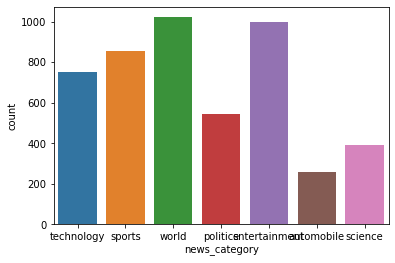

In [8]:
# countplot for balanced or imbalanced dataset checking
sns.countplot(df.news_category)

In [9]:
# checking for values in each target category
df['news_category'].value_counts()

world            1021
entertainment     998
sports            856
technology        751
politics          546
science           389
automobile        256
Name: news_category, dtype: int64

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\0023ND744\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\0023ND744\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\0023ND744\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# single function for removing stop words , tokenize,lemmatize
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

my_stopwords = ['make', 'like',  'news','new' ,'time', 'u','s','get', 'say']
def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_stopwords
  
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text)    
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

In [12]:
# joining 2 columns 

df['text'] = df['news_headline'] + " " + df['news_article']

In [13]:
# checking if cleaning function works

df.text[5]

'Parliamentary panel divided over key issues in Data Protection Bill: Report The members of the Joint Parliamentary Committee are divided over key issues in the Personal Data Protection Bill, 2019, such as the provision allowing government access to sensitive data of citizens without their consent and data localisation, ET reported. The panel, chaired by BJP MP Meenakashi Lekhi, has held consultations with stakeholders like Facebook, Twitter, Google, Ola, Uber and Paytm.'

In [14]:
clean_txt(df.text[5])

'parliamentary panel divide key issue data protection bill report members joint parliamentary committee divide key issue personal data protection bill provision allow government access sensitive data citizens without consent data localisation report panel chair bjp meenakashi lekhi hold consultations stakeholders facebook twitter google ola uber paytm'

In [15]:
df['clean_text'] = df['text'].apply(lambda x: clean_txt(x))

In [16]:
# train test split

X, y = df['clean_text'], df['news_category']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)

(3853,)
(964,)


In [19]:
from sklearn.linear_model import LogisticRegression

In [23]:
pipe_lr = Pipeline([('tfidf', TfidfVectorizer()),
 ('model', LogisticRegression())])

model = pipe_lr.fit(X_train, y_train)
prediction = model.predict(X_test)

In [24]:
# print metrics
print(confusion_matrix(y_test,prediction))

[[ 39   0   0   0   0   1   0]
 [  0 179   1   0   1   0   1]
 [  0   0 110   0   0   0   0]
 [  0   0   0  64   0  12  11]
 [  0   3   0   0 167   0   2]
 [  6   0   0   4   0 139   7]
 [  0   0   0   1   0  14 202]]


In [25]:
print(classification_report(y_test,prediction))

               precision    recall  f1-score   support

   automobile       0.87      0.97      0.92        40
entertainment       0.98      0.98      0.98       182
     politics       0.99      1.00      1.00       110
      science       0.93      0.74      0.82        87
       sports       0.99      0.97      0.98       172
   technology       0.84      0.89      0.86       156
        world       0.91      0.93      0.92       217

     accuracy                           0.93       964
    macro avg       0.93      0.93      0.93       964
 weighted avg       0.94      0.93      0.93       964



In [32]:
# multiple pipelines

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [33]:

# random forest pipeline

pipe_rf = Pipeline([('tfidf', TfidfVectorizer()),
            ('clf', RandomForestClassifier())])

# svm pipeline

pipe_svm = Pipeline([('tfidf', TfidfVectorizer()),
            ('clf', svm.SVC())])

In [34]:
# Set grid search params
param_range = [9, 10]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range}]

In [43]:
# Fit the grid search objects

clf_1 = GridSearchCV(pipe_rf, grid_params_rf)
clf_1.fit(X_train, y_train)
print("Best Score: ", clf_1.best_score_)
print("Best Params: ", clf_1.best_params_)

Best Score:  0.7648562332609025
Best Params:  {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_split': 10}


In [44]:
clf_2 = GridSearchCV(pipe_svm, grid_params_svm)
clf_2.fit(X_train, y_train)
print("Best Score: ", clf_2.best_score_)
print("Best Params: ", clf_2.best_params_)

Best Score:  0.9278488048916064
Best Params:  {'clf__C': 9, 'clf__kernel': 'linear'}


In [46]:
# perform predictions 

predictions_RF = clf_1.predict(X_test)


In [47]:
print(classification_report(y_test,predictions_RF))

               precision    recall  f1-score   support

   automobile       0.94      0.40      0.56        40
entertainment       0.77      0.96      0.85       182
     politics       1.00      0.82      0.90       110
      science       0.79      0.13      0.22        87
       sports       0.98      0.85      0.91       172
   technology       0.84      0.52      0.64       156
        world       0.54      0.91      0.67       217

     accuracy                           0.74       964
    macro avg       0.83      0.66      0.68       964
 weighted avg       0.80      0.74      0.72       964



In [48]:
predictions_SVM = clf_2.predict(X_test)

In [49]:
print(classification_report(y_test,predictions_SVM))

               precision    recall  f1-score   support

   automobile       0.89      1.00      0.94        40
entertainment       0.97      0.98      0.98       182
     politics       0.97      1.00      0.99       110
      science       0.93      0.86      0.89        87
       sports       0.98      0.97      0.98       172
   technology       0.85      0.89      0.87       156
        world       0.95      0.91      0.93       217

     accuracy                           0.94       964
    macro avg       0.93      0.94      0.94       964
 weighted avg       0.94      0.94      0.94       964



In [55]:
# print accuracy for RF and SVM

print("Accuracy score for RF based model:", accuracy_score(y_test,predictions_RF))
print("Accuracy score for SVM based model:", accuracy_score(y_test,predictions_SVM))

Accuracy score for RF based model: 0.7437759336099585
Accuracy score for SVM based model: 0.9408713692946058


In [56]:
# # import joblib
from joblib import dump

dump(pipe_svm, filename="SVM_mc_nc.joblib")

['SVM_mc_nc.joblib']

In [58]:
# load the saved model
from joblib import load
best_pipeline = load("SVM_mc_nc.joblib")